# GAUSSIAN PROCESSES EXAMPLE

### A small excersise on basic Gaussian Processes from chapter 2 of 'Gaussian Processes for Machine Learning' by C. E.Rasmussen and C. K. I. Williams.


Gaussian Processes are one of the most powerful tools Machine Learning has to offer, especially in the context of regression. They're also a great gateway into the world of Bayesian Inference and, quite frankly, a very beautiful framework. 

Broadly speaking, in a Bayesian setting we initially make an assumption about the nature of the data, called the *prior* distribution. We then update this prior assumption with the information contained in the training data. This updated prior distribution is called the *posterior* distribution. Once we have calculated the posterior distribution, we can obtain the *predictive* distribution by averaging the output of all possible models for a given test input with regard to the posterior distribution.

In the case of a Gaussian process the approach is slightly different. We indeed start with a prior distribution, but instead of using the training data to compute a generalizing function (the posterior) which is then used to generate predictions in the face of test inputs, we wait until we have both the training data *and* a test input (or inputs) to directly produce the predictive distribution. In other words, a Gaussian process is an example of a *lazy learning* algorithm.

In this notebook we'll illustrate a simple, one-dimensional example to get to grips with the basics. But first, let's import some libraries.

In [1]:
import numpy as np
from numpy.linalg import norm
from numpy.linalg import cholesky as chol
from numpy.random import multivariate_normal as multi_norm
import matplotlib.pyplot as plt

eps = 1e-5 # a small epsilon for numerical stability purposes

/Users/oghinde/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Squared Exponential covariance function

Let's start by defining the Squared-Exponential covariance function, also known as the Gaussian covariance function.

Intuitively, this covariance function sets a correlation between datapoints in such a way that points that are closer together will ten to be more similar than points that are further appart. Long lengthscales imply that this similarity spreads over a greater distance. This will become completely apparent when we look at some samples from the prior distribution.

In [7]:
def gauss_covar(X1, X2, length=1):
    """Compute Gaussian covariance matrix between two vectors.
    
    Keyword arguments:
    X1, X2 -- the input vectors
    length -- the lengthscale parameter (default 1)
    """
    K = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            K[i, j] = np.exp(-1/2*(norm(X1[i] - X2[j])/l)**2)
    return K

## Parameter Definition

All these parameters will affect the model's behaviour in different ways:
 - The lengthscale (`l`) affects the 'speed' of our prior distribution. Longer scales will give slower functions.
 - The noise variance (`sigma2`) will affect how noisy our observations are and worsen our prediction certainty.
 - The number of training samples (`n_tr`) and their distribution (`tr_dist`) will affect how well our model can capture the underlying distribution.
 
You should play with them and get a feel for what they do!

In [3]:
l = 1 # Covariance function lengthscale
sigma2 = 0.05 # observational noise
n_tr = 7 # number of training samples
tr_dist = 0 # training samples are spread linearly (0) or randomly (1)

## Prior Distribution

Let's see what our prior distribution looks like. In other words, let's visualize what we initially assume is the nature of whatever function that generated the data. We don't know what this function is (in fact, you can never know *exactly* what it is unless your name is Gandalf or the Great Cthulhu) but we can make some *reasonable* initial guesses as to what it may look like. Reasonable in the context of probabilistic priors can mean many things (very often the focus is on analytical convenience rather than realism). Our prior in this case is a Gaussian process that is governed by two parameters: a mean function and a covariance function. Note that here our prior mean is always 0 and our covariance function is the Gaussian covariance function. In practise this doesen't always have to be the case. In fact, a lot of the power of Gaussian Processes resides in the covariance function and the many forms it can take.

You'll see that all samples from the prior may wander about but they mostly tend to be centered around 0. Indeed, if we generated suffciently (infinintely) long samples we'd see that their mean value is exactly 0.

You'll also notice that, if you play with the lengthscale of the covariance function, these sample functions will be either "slow" or "fast". This will have a strong influence in the ability of our model to learn the underlying data distribution. In the real world, this hyperparameter must be properly adjusted to avoid model overfitting, and there are multiple ways one can achieve this. For now we'll simply explore the effects of the lengthscale on the model's behaviour.

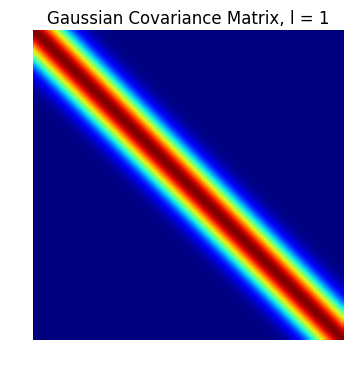

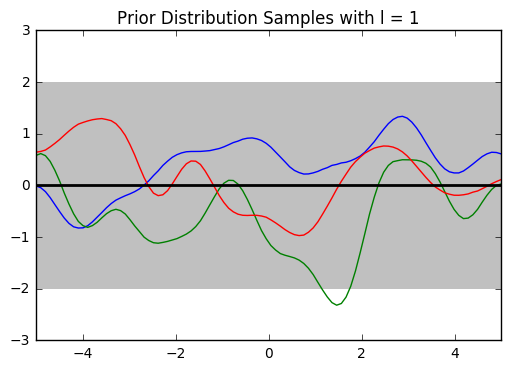

In [4]:
# Generate and view the covariance matrix for the prior distribution
X = np.linspace(-5, 5, 100) # set of samples for plotting purposes
m = np.zeros_like(X) # our prior has mean 0
K = gauss_covar(X, X, length=l)

fig = plt.figure()
plt.imshow(K)
plt.axis('off')
plt.title('Gaussian Covariance Matrix, l = {}'.format(l))
plt.show()

# Compute Cholesky decomposition of K
# Add eps to prevent numerical instabilities
L = chol(K + np.eye(len(X))*eps)

# Plot some samples from the prior distribution
upper = m + 2*np.sqrt(np.diag(K))
lower = m - 2*np.sqrt(np.diag(K))
fig = plt.figure()
plt.fill_between(X, upper, lower, facecolor='silver', linewidth=0)
for i in range(3):
    u = multi_norm(np.zeros_like(X), np.eye(len(X)))
    f = m + np.dot(L, u)
    plt.plot(X, f)
plt.plot(X, m, 'k', linewidth=2)
plt.axis([-5, 5, -3, 3])
plt.title('Prior Distribution Samples with l = {}'.format(l))
plt.show()

## Noiseless Observations

We'll now generate a bunch of points from a sine function. We choose a sine simply because it's an example of a completely non linear function that will illustrate the power of our Gaussian process pretty well. These points are our training dataset. Our job is to incorporate into the prior the information contained in the training data. We also have a bunch of test points that we'll use to compute and visualize our predictive distribution.

For this first example we'll proceed assumig there is no noise in the data. Although this scenario isn't necessarily realistic, it will act as a stepping stone towards the complete noisy model.

Note that in this case both the mean of the predictive distribution as well as any predictive sample functions will go *exactly* through the training data points. This will stop being the case as soon as we add noise to the observations.  

Also notice how the confidence level (the shaded portion of the graphs, representing plus-minus two standard deviations from the mean) is very high at the training data points (zero predictive variance), but quickly decreases as we move away from them. This will aslo change as we add observational noise. Another important behaviour to notice is how the predictive mean and variance will shift towards the prior mean and variance as we move away from the training datapoints. This means that, much like us humans, the algorithm goes back to it's old ways and beliefs when it has no data to learn from (set `tr_dist` = 0 and `n_tr` = 2 to see this better).

**NOTE:** we're resolving all linear systems the "wrong" way, by actually inverting the matrix. Please forgive me, oh Gods of Numerical Computation, but I think it's more didactic this way.
In the real world you should use the Cholesky factorisation of the covariance matrix K_tr. Here we only use the Cholesky factorisation to sample from the different distributions. In general, whenever you see something ineficcient in the code that follows, it's probably (hopefully) done for the sake of clarity.

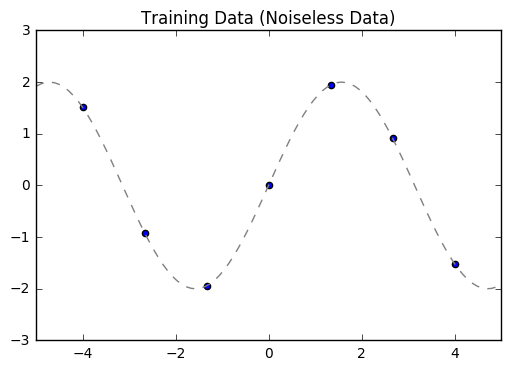

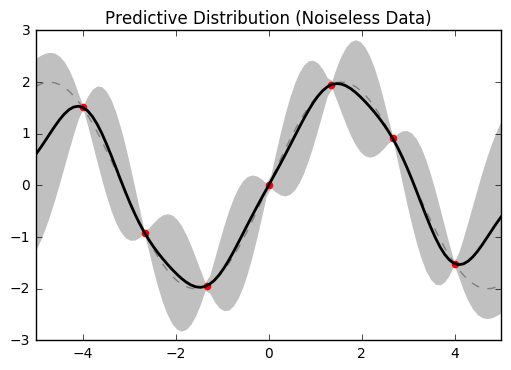

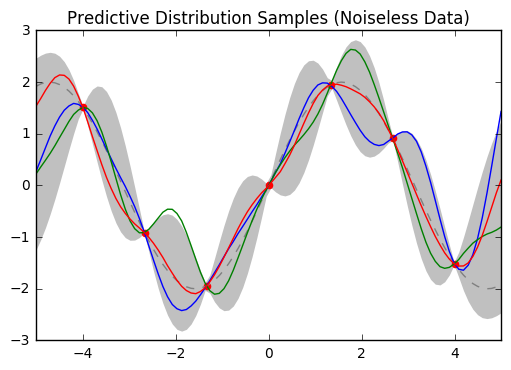

In [5]:
# Generate a bunch of training and test samples (without noise)
if tr_dist == 0:
    X_tr = np.linspace(-4, 4, n_tr)
else:
    X_tr = np.random.uniform(-5, 5, size=(n_tr,))
y_tr = np.sin(X_tr)*2
X_tst = np.linspace(-5, 5, 100)
y_tst = np.sin(X_tst)*2

# Plot the training data points
fig = plt.figure()
plt.plot(X_tst, np.sin(X_tst)*2, '--', color='grey')
plt.scatter(X_tr, y_tr)
plt.axis([-5, 5, -3, 3])
plt.title('Training Data (Noiseless Data)')
plt.show()

# Compute all covariance matrices
K_tr = gauss_covar(X_tr, X_tr, length=l)
K_tr_inv = np.linalg.inv(K_tr+np.eye(len(X_tr))*eps)
K_tst = gauss_covar(X_tst, X_tst, length=l)
K_trtst = gauss_covar(X_tr, X_tst, length=l)
K_tsttr = K_trtst.T

# Compute the predictive distribution mean and covariance
m_pred = K_tsttr.dot(K_tr_inv).dot(y_tr)
K_pred = K_tst - K_tsttr.dot(K_tr_inv).dot(K_trtst)

# Compute Cholesky decomposition of K_pred
# Add eps to prevent numerical instabilities
L_pred = chol(K_pred + np.eye(len(X_tst))*eps)

# Plot the predictive distribution
upper = m_pred + 2*np.sqrt(np.diag(K_pred))
lower = m_pred - 2*np.sqrt(np.diag(K_pred))
fig = plt.figure()
plt.fill_between(X_tst, upper, lower, facecolor='silver', linewidth=0)
plt.plot(X_tst, np.sin(X_tst)*2, '--', color='grey')
plt.plot(X_tst, m_pred, 'k', label='Predictive mean', linewidth=2)
plt.scatter(X_tr, y_tr, color='r')
#plt.plot(X_tst, y_tst, '--')
plt.axis([-5, 5, -3, 3])
plt.title('Predictive Distribution (Noiseless Data)')
plt.show()

# Plot some samples from the predictive distribution
fig = plt.figure()
plt.fill_between(X_tst, upper, lower, facecolor='silver', linewidth=0)
plt.plot(X_tst, np.sin(X_tst)*2, '--', color='grey')
for i in range(3):
    u = multi_norm(np.zeros_like(X_tst), np.eye(len(X_tst)))
    f = m_pred + np.dot(L_pred, u)
    plt.plot(X_tst, f)
plt.scatter(X_tr, y_tr, color='r')
plt.axis([-5, 5, -3, 3])
plt.title('Predictive Distribution Samples (Noiseless Data)'.format(l))
plt.show()

## Noisy Observations

Let's add some observational noise. Here we cheat a little bit in that our model uses exactly the same noise value that has been used to generate the data. In the real world we don't really know what this noise is like, so we have to make assumptions (generally we'll just assume that it's additive white noise and call it a day). Indeed the noise variance is another hyperparameter that must be adjusted together with any hyperparameters from the correlation function (like, in this case, the lengthscale).

Notice how everything becomes fuzzier now: neither the predictive mean nor the samples from the predictive distribution pass exactly through the training datapoints anymore; also, our confidence intervals have widened (we no longer have zero variance at the training datapoints, for instance).



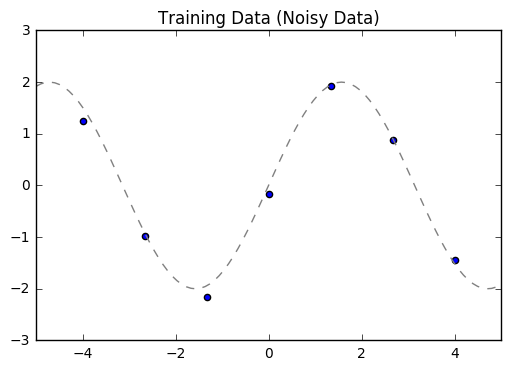

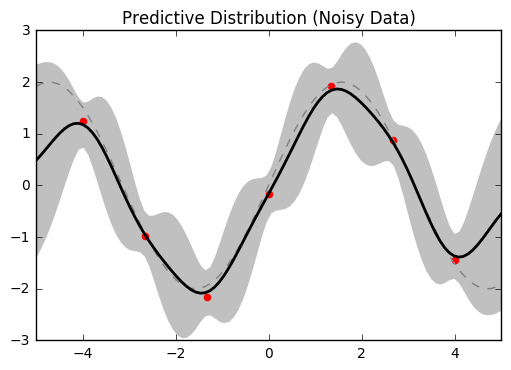

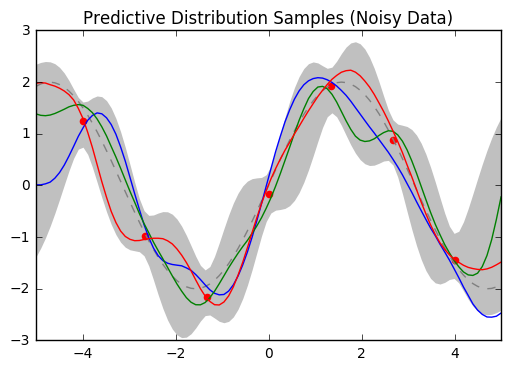

In [6]:
# Add some noise
y_tr += np.random.normal(loc=0, scale=np.sqrt(sigma2), size=X_tr.shape)
y_tst += np.random.normal(loc=0, scale=np.sqrt(sigma2), size=X_tst.shape)

# Plot the noisy data points
fig = plt.figure()
plt.plot(X_tst, np.sin(X_tst)*2, '--', color='grey')
plt.scatter(X_tr, y_tr)
plt.axis([-5, 5, -3, 3])
plt.title('Training Data (Noisy Data)')
plt.show()

# Compute all covariance matrices
K_tr = gauss_covar(X_tr, X_tr, length=l) + sigma2*np.eye(len(X_tr))
K_tr_inv = np.linalg.inv(K_tr+np.eye(len(X_tr))*eps)
K_tst = gauss_covar(X_tst, X_tst, length=l)
K_trtst = gauss_covar(X_tr, X_tst, length=l)
K_tsttr = K_trtst.T

# Compute the predictive distribution mean and covariance
m_pred = K_tsttr.dot(K_tr_inv).dot(y_tr)
K_pred = K_tst - K_tsttr.dot(K_tr_inv).dot(K_trtst)

# Compute Cholesky decomposition of K_pred
# Add eps to prevent numerical instabilities
L_pred = chol(K_pred + np.eye(len(X_tst))*eps)

# Plot the predictive distribution
upper = m_pred + 2*np.sqrt(np.diag(K_pred))
lower = m_pred - 2*np.sqrt(np.diag(K_pred))
fig = plt.figure()
plt.fill_between(X_tst, upper, lower, facecolor='silver', linewidth=0)
plt.plot(X_tst, np.sin(X_tst)*2, '--', color='grey')
plt.plot(X_tst, m_pred, 'k', label='Predictive mean', linewidth=2)
plt.scatter(X_tr, y_tr, color='r')
plt.axis([-5, 5, -3, 3])
plt.title('Predictive Distribution (Noisy Data)')
plt.show()

# Plot some samples from the predictive distribution
fig = plt.figure()
plt.fill_between(X_tst, upper, lower, facecolor='silver', linewidth=0)
plt.plot(X_tst, np.sin(X_tst)*2, '--', color='grey')
for i in range(3):
    u = multi_norm(np.zeros_like(X_tst), np.eye(len(X_tst)))
    f = m_pred + np.dot(L_pred, u)
    plt.plot(X_tst, f)
plt.scatter(X_tr, y_tr, color='r')
plt.axis([-5, 5, -3, 3])
plt.title('Predictive Distribution Samples (Noisy Data)'.format(l))
plt.show()